# Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 一、案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC 要求 最佳结果>0.7 , 最差结果>0.55
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、数据概览

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列 ID，标识了每一个测试的样例。

In [131]:
import pandas as pd 
train_df = pd.read_csv('./data/train.csv', sep='\t')
train_label = train_df['label']
test_df = pd.read_csv('./data/test.csv',sep='\t')
test_label = pd.read_csv('./groundTruth.csv')


In [132]:
print(f"train dataframe size: {train_df.shape}")
print(f"train label     size: {train_label.shape}")
print(f"test dataframe  size: {test_df.shape}")
print(f"test label      size: {test_label.shape}")
test_label.head(2)

train dataframe size: (57039, 7)
train label     size: (57039,)
test dataframe  size: (11208, 5)
test label      size: (11208, 2)


,Id,Expected
0,0,0
1,1,0


## 数据加载
- 训练数据 train_df
- 训练标签 train_label
- 测试数据 test_df
- 测试标签 test_label
## 特征处理
1. 将 训练、测试数据中的文本向量化 

In [133]:

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 2000
tfidf_vectorizer = TfidfVectorizer(
    max_features= max_features,        # 最多提取x个词（特征维度）
    min_df=  500  ,                      # 至少在 x 个文档中出现
    max_df= 0.3                        # 在 x %以下的文档中出现
)
X_train = tfidf_vectorizer.fit_transform(train_df['reviewText'].tolist())
X_test = tfidf_vectorizer.transform(test_df['reviewText'].tolist())

y_train = np.array(train_label.tolist())
y_test = test_label['Expected'].tolist()


# 降采样一下，台式机在跑别的，小笔记本顶不住
train_size = 5000
test_size = 500
X_train = X_train[0:train_size]
y_train = y_train[0:train_size]

X_test =  X_test[0:test_size]
y_test =  y_test[0:test_size]
model_roc = {}

In [ ]:
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import copy

# 向量机输出的是距离,需要转换成概率
def normalize_score_minmax(score):
    score = np.array(score)
    if np.all(score == score[0]):  # 防止除零错误
        return np.ones_like(score) * 0.5
    min_score, max_score = score.min(), score.max()
    return (score - min_score) / (max_score - min_score)

class SelfBagging:
    def __init__(self, base_classifier, num_classifier:int):
        # base_classsifier: type of classifier; num_classifier: number of classifier
        self.num_classifier = num_classifier
        self.base_classifier =  [copy.deepcopy(base_classifier) for i in range(self.num_classifier)]
    
    def fit(self, X_train, y_train):
        for i in range(self.num_classifier):
            # booststrap sampling
            np.random.seed(1200)
            indices = np.random.choice(len(y_train), len(y_train), replace=True)
            X_sampled, y_sampled = X_train[indices], y_train[indices]
            self.base_classifier[i].fit(X_sampled , y_sampled)
        return


    def predict(self, X_test):
        # return y_pred
        y_pred =  np.zeros(X_test.shape[0]) 
        for c in self.base_classifier:
            if hasattr(c, "predict_proba"):
                y_pred += c.predict_proba(X_test)[:, 1]
            elif hasattr(c, "decision_function"):
                y_pred += c.decision_function(X_test) #点到超平面的距离
        y_pred /= self.num_classifier
        return y_pred

In [145]:
bagging_dt= SelfBagging(base_classifier=DecisionTreeClassifier(max_depth=6, class_weight='balanced'), num_classifier=10)
bagging_dt.fit(X_train, y_train)
bagging_dt_y_pred = bagging_dt.predict(X_test)
bagging_dt_roc = roc_auc_score(y_test , bagging_dt_y_pred)
print(bagging_dt_roc)
print(bagging_dt_y_pred[:2])


0.6241097793989925
[0.37017218 0.37017218]


In [150]:
bagging_svc = SelfBagging(base_classifier=LinearSVC(class_weight='balanced'), num_classifier=3)
bagging_svc.fit(X_train, y_train)

bagging_svc_y_pred = normalize_score_minmax(bagging_svc.predict(X_test))
bagging_svc_dt_roc = roc_auc_score(y_test , bagging_svc_y_pred)
print(bagging_svc_dt_roc)

0.696121491848433


In [ ]:
print(bagging_svc_y_pred[0:2])

[0.4349233  0.37555599]


In [137]:

class SelfAdaBoostM1:
    def __init__(self, base_classifier, num_classifier:int):
        # base_classsifier: type of classifier; num_classifier: number of classifier
        self.num_classifier = num_classifier
        self.base_classifier =  [copy.deepcopy(base_classifier) for i in range(self.num_classifier)]
        self.betas = [] # vote weights
    
    def fit(self, X_train, y_train):
        num_samples = len(y_train)
        weight = np.ones(num_samples) / num_samples  # 初始权重归一化
        self.classifiers = []  # 实际保留的有效弱分类器
        self.betas = []        # 对应的 alpha 权重（即 log(1 / beta)）

        for i in range(self.num_classifier):
            # 克隆新弱分类器
            clf = copy.deepcopy(self.base_classifier[i])
            clf.fit(X_train, y_train, sample_weight=weight)
            y_pred = clf.predict(X_train)

            # 计算错误率
            error_mask = y_pred != y_train
            error = np.sum(weight[error_mask])

            # 如果误差过大，放弃该分类器
            if error > 0.5:
                break

            # 计算 beta 和 alpha（加权投票权重）
            beta = error / (1 - error)
            alpha = np.log(1 / beta)

            # 更新样本权重
            weight *= np.where(error_mask, 1, beta)
            weight /= np.sum(weight)  # 归一化成概率分布

            # 保存有效分类器及其投票权重
            self.classifiers.append(clf)
            self.betas.append(alpha)
        print("Ada boost valid classifier size:" , len(self.classifiers))

    def predict(self, X_test):
        total_preds = []

        for clf in self.classifiers:
            if hasattr(clf, "predict_proba"):
                pred_score = clf.predict_proba(X_test)[:, 1]
            elif hasattr(clf, "decision_function"):
                pred_score = clf.decision_function(X_test)
            else:
                pred_score = clf.predict(X_test)  # fallback: 0/1
            total_preds.append(pred_score)

        total_preds = np.array(total_preds)  # shape: (n_classifiers, n_samples)
        betas = np.array(self.betas)         # shape: (n_classifiers,)

        # 加权求和后得到得分
        weighted_scores = np.dot(betas, total_preds) / np.sum(betas)
        return weighted_scores  # 返回得分（如用于 AUC、sigmoid 二分类等）

In [138]:

Ada_dt= SelfAdaBoostM1(base_classifier=DecisionTreeClassifier(max_depth=3, class_weight='balanced'), num_classifier=10)
Ada_dt.fit(X_train, y_train)
Ada_dt_pred = Ada_dt.predict(X_test)
Ada_dt_roc = roc_auc_score(y_test , Ada_dt_pred)
print(Ada_dt_roc)

Ada boost valid classifier size: 3
0.6462939527035411


In [152]:
Ada_svc = SelfAdaBoostM1(base_classifier=LinearSVC(class_weight='balanced'), num_classifier=5)
Ada_svc.fit(X_train, y_train)

Ada_svc_pred = normalize_score_minmax(Ada_svc.predict(X_test))
Ada_svc_roc = roc_auc_score(y_test , Ada_svc_pred)
print(Ada_svc_roc)

Ada boost valid classifier size: 3
0.7275862924638328


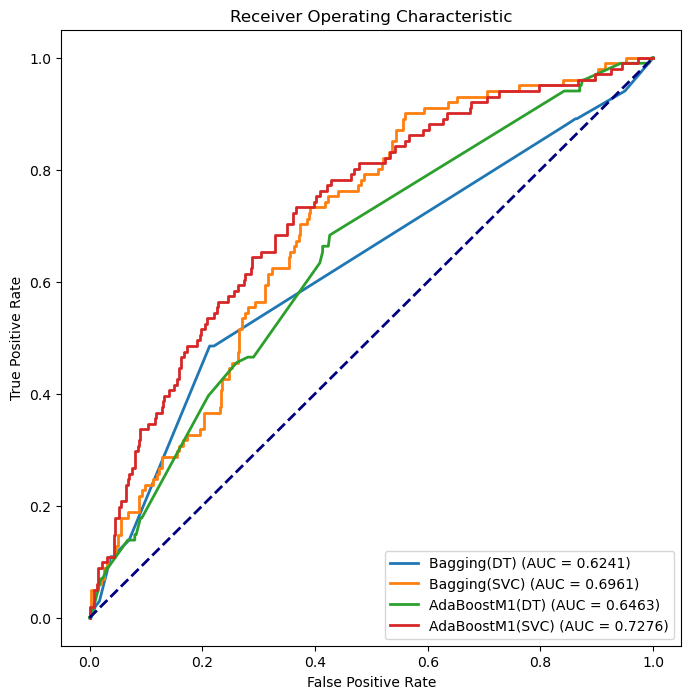

In [141]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 绘制 ROC 曲线
def plot_all_roc_curves(y_true, model_roc):
    plt.figure(figsize=(8, 8))

    for label, y_pred_prob in model_roc.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.4f})'.format(label, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

model_roc["Bagging(DT)"]    = bagging_dt_y_pred
model_roc["Bagging(SVC)"]   = bagging_svc_y_pred
model_roc["AdaBoostM1(DT)"] = Ada_dt_pred
model_roc["AdaBoostM1(SVC)"]= Ada_svc_pred
plot_all_roc_curves(y_test, model_roc)

## 四、云平台提交格式

提交文件需要对测试集中每一条评论给出预测为高质量的概率，每行包括一个 ID（和测试集对应）以及预测的概率 Prediction（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
ID,Prediction
0,0.9
1,0.45
2,0.78
...
```

文件命名没有要求。

In [154]:
id_test = test_df['Id'].tolist()[0:test_size]
result_df = pd.DataFrame()
result_df['ID'] = id_test
result_df['Prediction'] = Ada_dt_pred  # 保留两位小数
result_df.to_csv('./result.csv', index=False)

**注意除了提交云平台，还需要像之前作业一样在学堂在线提交代码和报告（不包括数据）**

# Report
## 功能实现步骤：
1. 读取原始数据
2. 选取文本特征将其向量化
3. __自定义实现通用的Bagging AdaBoost.M1 类，支持决策树和SVC两种base classifier，提供统一的 fit，predict接口__
4. 完成训练和预测，Auc指标上： \
    Bagging:决策树/SVC = __0.6241__/0.6961; \
    AdaBoost.M1:决策树/SVC= 0.646/__0.7276__(出图详见上文); \
    最高分组合是基于SVC的AdaBoost方法0.7276>0.7,最低分是基于决策树的Bagging方法0.6241>0.5 
5. 按照格式要求 输出 作业要求的文件（__SVC输出的是样本距离分类超平面的距离,已经转换成概率__）
## 结果分析：
1. AdaBoost的结果由于Bagging的结果：\
    个人理解是 AdaBoost有提升样本错误的关注度这一机制，相较于 Bagging的独立训练、独立投票，能够 使得分类更好的模型实例 投出最多的票。\
    从原理的直观感觉上出发 AdaBoost 更像是强调“纠错”，Bagging 像是强调“减方差”。
2. 两种集成学习方法中 都是SVM 优于 决策树： \
    原因可能是：SVC适合本次任务的高维稀疏数据。而决策树分裂基于单维特征，在高维稀疏空间中容易“盲目分裂”，容易开始胡说八道。\
    还有一种可能 是决策树相较于SVC更容易过拟合
3. 遗憾：在完成作业之后突然想到，可能局限了，说不定可以尝试一下AdaBoost模型同时使用SVC和贝叶斯分类这种
